In [1]:
import os
import concurrent.futures
import pandas as pd
import geopandas as gpd
import requests
from tqdm import tqdm
from PIL import Image
from sklearn.cluster import MeanShift
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from skimage.color import rgb2hsv
from skimage.filters.rank import modal
from skimage import io, segmentation, color, filters
from skimage.segmentation import felzenszwalb
from skimage.color import label2rgb

In [ ]:
# 画像の保存先ディレクトリ
IMAGE_DIR = "tokuyama_images"

In [ ]:
points = gpd.read_file("/workspace/app/Green-View-Index/tokuyama/points_tokuyama/tokuyama_points_200.shp")
max_id = points["point_id"].max()
headings = [0, 60, 120, 180, 240, 300]
pitch = 0

In [ ]:
import numpy as np
from skimage.color import rgb2hsv


def extract_greenery(image):
    """緑の領域を抽出してマスクを作成 (RGB値は0〜255のまま使用)"""

    # 画像をHSVカラー空間に変換
    hsv_image = rgb2hsv(image)

    # Hueチャネルを抽出 (0〜1の範囲なので360度スケールに変換)
    hue = hsv_image[:, :, 0] * 360  # Hueを360度スケールに変換
    # Saturationチャンネルを抽出 (0〜1の範囲なのでパーセンテージ表記に変換)
    sat = hsv_image[:, :, 1] * 100  # Saturationをパーセンテージ表記に変換
    # Valueチャンネルを抽出 (0〜1の範囲なのでパーセンテージ表記に変換)
    val = hsv_image[:, :, 2] * 100  # Valueをパーセンテージ表記に変換

    # 緑色の範囲 (55 <= Hue <= 180) のセグメントを抽出
    mask = (hue > 50) & (hue < 180)

    # 除外する (sat, val) の矩形領域を定義
    exclusion_mask = (
        (sat <= 10) & (val >= 65)) | (  # (0 <= sat <= 20, val >= 50)
        (sat <= 10) & (val <= 65)
    )  # (0 <= sat <= 20, val <= 50)

    # 除外領域をマスクから除外
    mask = mask & (~exclusion_mask)

    return mask

In [ ]:
def calculate_gvi(green_mask):
    """GVIを計算する関数"""

    # 緑のピクセル数をカウント
    green_pixel_count = np.sum(green_mask)

    # 画像全体のピクセル数を取得
    total_pixel_count = green_mask.size

    # ピクセル数がゼロの場合の対処
    if total_pixel_count == 0:
        return 0  # 画像が無効な場合はGVIを0に設定

    # GVIの計算（緑のピクセルの割合）
    gvi = (green_pixel_count / total_pixel_count) * 100  # パーセンテージ表記

    return gvi

In [ ]:
def process_point(idx_point):
    """Function to process a single point"""
    idx, point = idx_point
    point_id = point["point_id"]
    gvi = 0
    valid_headings = 0  # Count of headings with valid images

    for heading in headings:
        image_path = f"{IMAGE_DIR}/{point_id}_{heading}_{pitch}.jpg"
        if not os.path.exists(image_path):
            continue
        image = io.imread(image_path)

        # セグメンテーションを実行
        segments = felzenszwalb(image, scale=200, min_size=50)
        # 各セグメントごとに平均色で画像を塗りつぶす
        segmented_image = label2rgb(segments, image, kind="avg")

        # Extract green mask
        green_mask = extract_greenery(segmented_image)
        # Calculate GVI
        gvi += calculate_gvi(green_mask)
        valid_headings += 1

    # Calculate average GVI
    if valid_headings > 0:
        gvi /= valid_headings
    else:
        gvi = np.nan  # Set to NaN if no valid images

    return idx, gvi

In [ ]:
# Prepare a list of tuples (index, point)
points_list = list(points.iterrows())

# Use ProcessPoolExecutor for multiprocessing
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Map the function to the points with a progress bar
    results = list(
        tqdm(executor.map(process_point, points_list), total=len(points_list), desc="Processing GVI for points")
    )

# Update the dataframe with GVI results
for idx, gvi in results:
    points.loc[idx, "gvi"] = gvi

: 

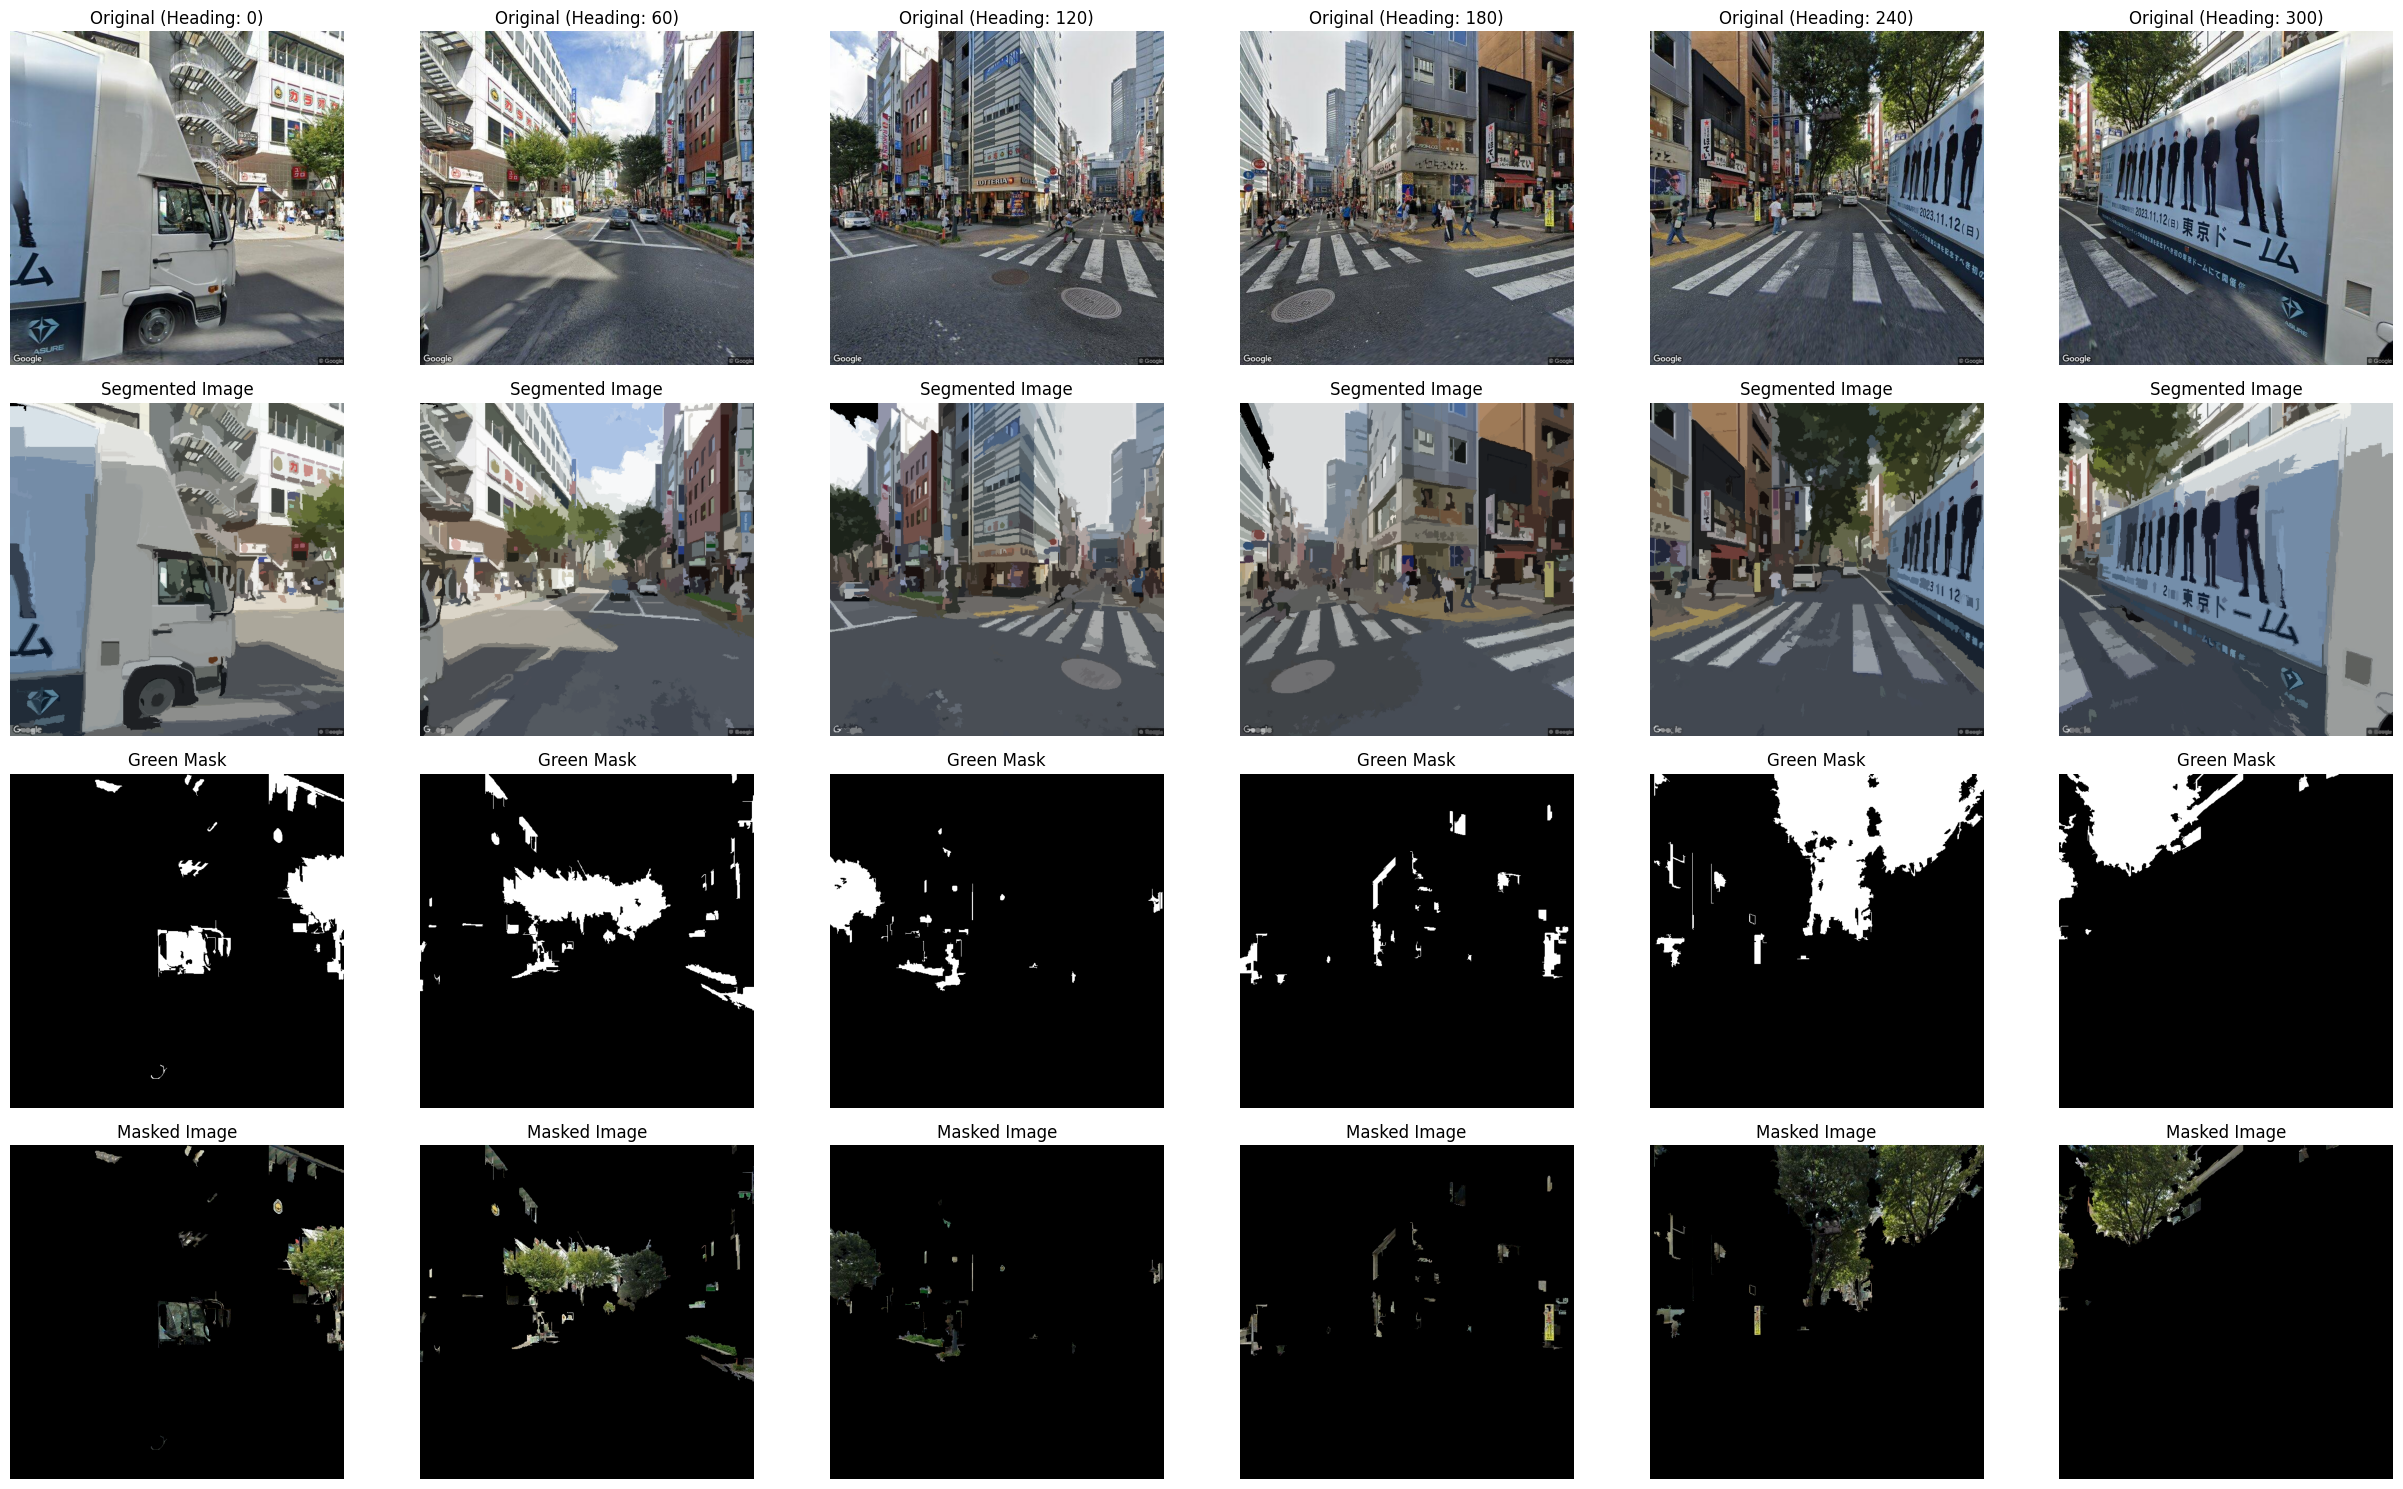

GVI: 7.902058919270833


In [ ]:
# import os
# import numpy as np
# import matplotlib.pyplot as plt
# from skimage.segmentation import felzenszwalb
# from skimage.color import label2rgb
# from skimage.io import imread

# # point_id = 1293
# point_id = 129
# # point_id = 263
# fig, ax = plt.subplots(4, len(headings), figsize=(25, 15))  # 3行に変更
# i = 0
# gvi = 0.0
# IMAGE_DIR = "/workspace/app/Green-View-Index/shibuya/shibuya_images"

# for heading in headings:
#     image_path = f"{IMAGE_DIR}/{point_id}_{heading}_{pitch}.jpg"
#     if not os.path.exists(image_path):
#         continue
#     image = imread(image_path)

#     # セグメンテーションを実行
#     segments = felzenszwalb(image, scale=200, min_size=50)

#     # 各セグメントごとに平均色で画像を塗りつぶす
#     segmented_image = label2rgb(segments, image, kind="avg")

#     # 緑色領域のマスクを抽出
#     green_mask = extract_greenery(segmented_image)

#     # マスクを使って元の画像から緑色領域のみを残す
#     masked_image = np.copy(image)
#     masked_image[~green_mask] = 0  # 緑色領域以外を黒に設定

#     # 1行目に元の画像を表示
#     ax[0, i].imshow(image)
#     ax[0, i].set_title(f"Original (Heading: {heading})")
#     ax[0, i].axis("off")
    
#     ax[1,i].imshow(segmented_image)
#     ax[1,i].set_title("Segmented Image")
#     ax[1,i].axis("off")

#     # 2行目に緑色領域のマスクを表示
#     ax[2, i].imshow(green_mask, cmap="gray")
#     ax[2, i].set_title("Green Mask")
#     ax[2, i].axis("off")

#     # 3行目にマスクを適用した画像を表示
#     ax[3, i].imshow(masked_image)
#     ax[3, i].set_title("Masked Image")
#     ax[3, i].axis("off")

#     # GVI計算
#     gvi += calculate_gvi(green_mask)
#     i += 1

# plt.tight_layout()
# plt.show()

# print(f"GVI: {gvi / len(headings)}")